# Polystyrene Stress Relaxation

Fit polystyrene relaxation at selectable temperature.

**Data:** examples/data/relaxation/polymers/stressrelaxation_ps130_data.csv (swap for other temps)


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import FractionalMaxwellModel, GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import os
import sys

import arviz as az

# Shared plotting utilities
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")), ".."))
from utils.plotting_utils import display_arviz_diagnostics


## Load relaxation data (select temperature file)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'relaxation' / 'polymers'
file = DATA_DIR / 'stressrelaxation_ps130_data.csv'  # swap for other temps
df = load_tab_file(file)
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.388098s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.9905e+08 | elapsed=1.388s | final_gradient_norm=3.9594e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.387077s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.9905e+08 | elapsed=0.387s | final_gradient_norm=3.9594e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.762464s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=2.3078e+09 | elapsed=0.762s | final_gradient_norm=2.0647e+12


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=5.771658s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3516.7560 | elapsed=5.772s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9997930896304674, 'fm_r2': -1.6576706292035563}


## Plot relaxation fits

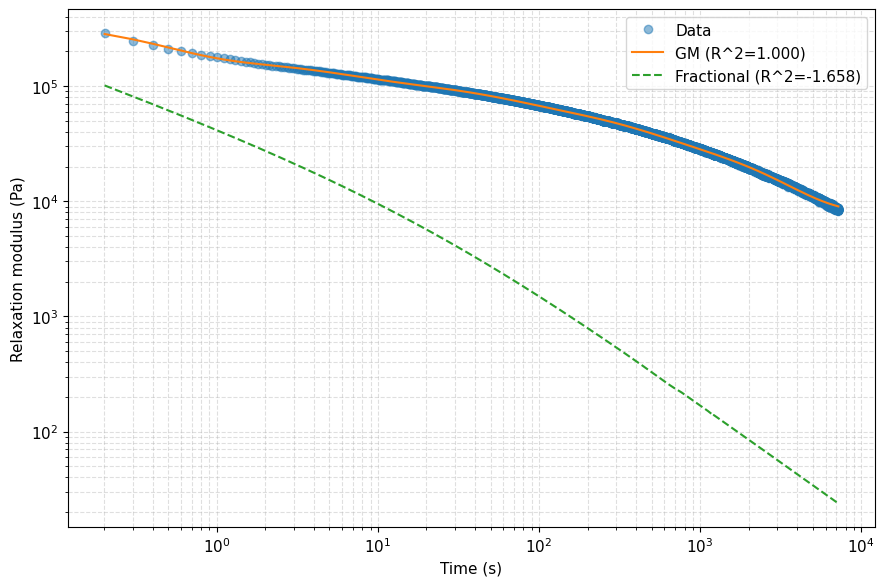

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.583817s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.9905e+08 | elapsed=0.584s | final_gradient_norm=3.9594e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.560758s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=4.9905e+08 | elapsed=0.561s | final_gradient_norm=3.9594e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.292767s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=2.3078e+09 | elapsed=0.293s | final_gradient_norm=2.0647e+12


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=5.715415s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3516.7560 | elapsed=5.715s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('gm', 1.0), ('fm', -1.658)]


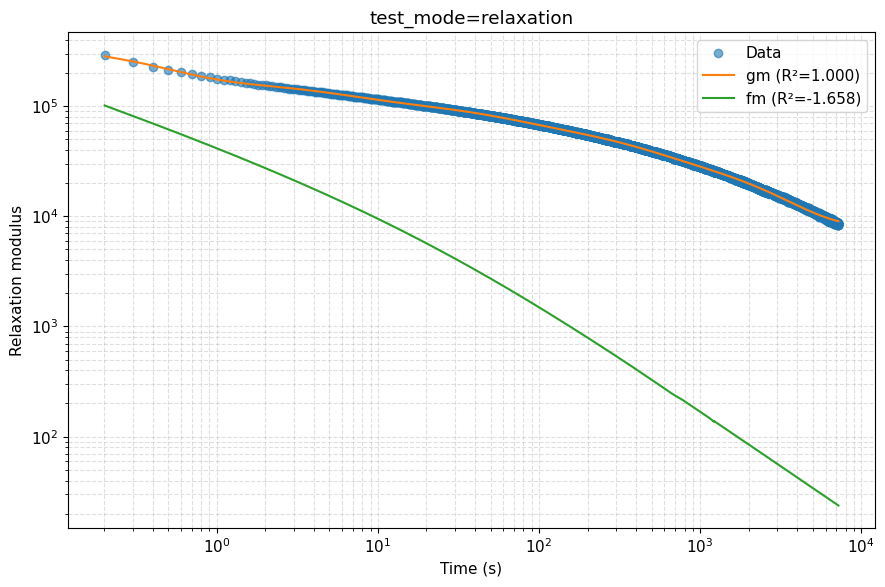

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<14:21,  1.23s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   4%|▍         | 30/700 [00:01<00:21, 30.71it/s, 31 steps of size 2.07e-04. acc. prob=0.77]

warmup:   7%|▋         | 47/700 [00:01<00:13, 46.89it/s, 63 steps of size 3.35e-04. acc. prob=0.81]

warmup:   9%|▉         | 62/700 [00:01<00:13, 46.02it/s, 255 steps of size 1.70e-04. acc. prob=0.82]

warmup:  10%|█         | 73/700 [00:02<00:14, 43.08it/s, 63 steps of size 2.52e-04. acc. prob=0.83] 

warmup:  12%|█▏        | 82/700 [00:02<00:13, 46.44it/s, 95 steps of size 1.50e-04. acc. prob=0.83]

warmup:  13%|█▎        | 90/700 [00:02<00:15, 38.95it/s, 127 steps of size 1.40e-04. acc. prob=0.83]

warmup:  14%|█▎        | 96/700 [00:02<00:15, 38.15it/s, 127 steps of size 1.13e-04. acc. prob=0.84]

warmup:  15%|█▍        | 102/700 [00:02<00:17, 34.85it/s, 255 steps of size 2.75e-03. acc. prob=0.84]

warmup:  15%|█▌        | 107/700 [00:03<00:18, 32.39it/s, 127 steps of size 1.40e-02. acc. prob=0.85]

warmup:  16%|█▌        | 113/700 [00:03<00:16, 35.16it/s, 255 steps of size 3.33e-03. acc. prob=0.85]

warmup:  17%|█▋        | 118/700 [00:03<00:19, 29.87it/s, 127 steps of size 1.36e-02. acc. prob=0.85]

warmup:  18%|█▊        | 124/700 [00:03<00:17, 33.11it/s, 255 steps of size 5.87e-03. acc. prob=0.85]

warmup:  18%|█▊        | 128/700 [00:03<00:17, 32.08it/s, 95 steps of size 1.29e-02. acc. prob=0.86] 

warmup:  19%|█▉        | 134/700 [00:03<00:16, 33.66it/s, 255 steps of size 5.22e-03. acc. prob=0.86]

warmup:  20%|█▉        | 138/700 [00:04<00:19, 29.47it/s, 127 steps of size 1.09e-02. acc. prob=0.86]

warmup:  20%|██        | 143/700 [00:04<00:17, 32.75it/s, 255 steps of size 6.69e-03. acc. prob=0.86]

warmup:  21%|██        | 147/700 [00:04<00:17, 30.76it/s, 127 steps of size 1.32e-02. acc. prob=0.86]

warmup:  22%|██▏       | 153/700 [00:04<00:14, 36.58it/s, 127 steps of size 2.23e-02. acc. prob=0.86]

warmup:  22%|██▏       | 157/700 [00:04<00:15, 33.99it/s, 255 steps of size 7.41e-03. acc. prob=0.86]

warmup:  23%|██▎       | 161/700 [00:04<00:16, 32.30it/s, 63 steps of size 1.50e-02. acc. prob=0.86] 

warmup:  24%|██▎       | 165/700 [00:04<00:16, 32.87it/s, 255 steps of size 2.39e-02. acc. prob=0.87]

warmup:  24%|██▍       | 170/700 [00:05<00:15, 34.25it/s, 255 steps of size 2.13e-02. acc. prob=0.87]

warmup:  25%|██▌       | 175/700 [00:05<00:13, 37.57it/s, 159 steps of size 9.42e-03. acc. prob=0.87]

warmup:  26%|██▌       | 180/700 [00:05<00:13, 39.53it/s, 127 steps of size 2.33e-02. acc. prob=0.87]

warmup:  26%|██▋       | 185/700 [00:05<00:12, 40.21it/s, 63 steps of size 2.15e-02. acc. prob=0.87] 

warmup:  27%|██▋       | 190/700 [00:05<00:13, 37.85it/s, 255 steps of size 8.54e-03. acc. prob=0.87]

warmup:  28%|██▊       | 194/700 [00:05<00:15, 33.44it/s, 127 steps of size 1.82e-02. acc. prob=0.87]

warmup:  29%|██▊       | 200/700 [00:05<00:13, 37.05it/s, 255 steps of size 1.61e-02. acc. prob=0.87]

sample:  29%|██▉       | 204/700 [00:05<00:14, 33.42it/s, 223 steps of size 1.61e-02. acc. prob=0.91]

sample:  30%|██▉       | 208/700 [00:06<00:14, 33.97it/s, 127 steps of size 1.61e-02. acc. prob=0.90]

sample:  30%|███       | 212/700 [00:06<00:14, 33.48it/s, 127 steps of size 1.61e-02. acc. prob=0.91]

sample:  31%|███       | 216/700 [00:06<00:14, 32.82it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  32%|███▏      | 223/700 [00:06<00:12, 39.65it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  33%|███▎      | 228/700 [00:06<00:11, 39.75it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  33%|███▎      | 234/700 [00:06<00:10, 42.61it/s, 255 steps of size 1.61e-02. acc. prob=0.93]

sample:  34%|███▍      | 239/700 [00:06<00:11, 39.99it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  35%|███▍      | 244/700 [00:06<00:11, 40.17it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  36%|███▌      | 249/700 [00:07<00:11, 39.18it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  36%|███▌      | 253/700 [00:07<00:11, 38.10it/s, 223 steps of size 1.61e-02. acc. prob=0.94]

sample:  37%|███▋      | 257/700 [00:07<00:12, 35.44it/s, 31 steps of size 1.61e-02. acc. prob=0.94] 

sample:  37%|███▋      | 261/700 [00:07<00:13, 32.29it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  38%|███▊      | 265/700 [00:07<00:13, 31.79it/s, 31 steps of size 1.61e-02. acc. prob=0.94] 

sample:  38%|███▊      | 269/700 [00:07<00:13, 32.70it/s, 255 steps of size 1.61e-02. acc. prob=0.93]

sample:  39%|███▉      | 273/700 [00:07<00:13, 32.07it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  40%|███▉      | 277/700 [00:08<00:15, 28.13it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  40%|████      | 281/700 [00:08<00:15, 27.89it/s, 255 steps of size 1.61e-02. acc. prob=0.93]

sample:  41%|████      | 285/700 [00:08<00:14, 29.50it/s, 127 steps of size 1.61e-02. acc. prob=0.93]

sample:  41%|████▏     | 289/700 [00:08<00:13, 30.29it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  42%|████▏     | 293/700 [00:08<00:14, 28.87it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  43%|████▎     | 299/700 [00:08<00:11, 35.60it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  43%|████▎     | 304/700 [00:08<00:10, 38.99it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  44%|████▍     | 309/700 [00:08<00:09, 40.14it/s, 31 steps of size 1.61e-02. acc. prob=0.94] 

sample:  45%|████▍     | 314/700 [00:09<00:10, 35.11it/s, 95 steps of size 1.61e-02. acc. prob=0.94]

sample:  46%|████▌     | 319/700 [00:09<00:10, 37.62it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  46%|████▌     | 323/700 [00:09<00:09, 37.93it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  47%|████▋     | 328/700 [00:09<00:09, 39.34it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  48%|████▊     | 333/700 [00:09<00:10, 34.97it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  48%|████▊     | 338/700 [00:09<00:09, 38.50it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  49%|████▉     | 343/700 [00:09<00:10, 34.77it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  50%|████▉     | 347/700 [00:10<00:10, 33.50it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  50%|█████     | 351/700 [00:10<00:10, 33.10it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  51%|█████     | 355/700 [00:10<00:10, 32.96it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  51%|█████▏    | 360/700 [00:10<00:09, 35.81it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  52%|█████▏    | 365/700 [00:10<00:09, 37.15it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  53%|█████▎    | 369/700 [00:10<00:09, 36.49it/s, 31 steps of size 1.61e-02. acc. prob=0.94] 

sample:  53%|█████▎    | 374/700 [00:10<00:08, 38.57it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  54%|█████▍    | 379/700 [00:10<00:08, 37.13it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  55%|█████▍    | 383/700 [00:11<00:09, 33.38it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  55%|█████▌    | 387/700 [00:11<00:10, 30.65it/s, 95 steps of size 1.61e-02. acc. prob=0.94] 

sample:  56%|█████▌    | 391/700 [00:11<00:09, 31.62it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  56%|█████▋    | 395/700 [00:11<00:10, 30.17it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  57%|█████▋    | 399/700 [00:11<00:09, 31.03it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  58%|█████▊    | 403/700 [00:11<00:09, 30.97it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  58%|█████▊    | 408/700 [00:11<00:08, 35.36it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  59%|█████▉    | 412/700 [00:11<00:08, 35.11it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  60%|█████▉    | 417/700 [00:12<00:07, 38.28it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  60%|██████    | 421/700 [00:12<00:08, 32.15it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  61%|██████    | 425/700 [00:12<00:08, 32.89it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  61%|██████▏   | 429/700 [00:12<00:07, 34.35it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  62%|██████▏   | 434/700 [00:12<00:07, 36.83it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  63%|██████▎   | 438/700 [00:12<00:07, 33.82it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  63%|██████▎   | 442/700 [00:12<00:07, 33.72it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  64%|██████▍   | 447/700 [00:12<00:06, 37.26it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  64%|██████▍   | 451/700 [00:13<00:07, 34.89it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  65%|██████▌   | 455/700 [00:13<00:07, 33.25it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  66%|██████▌   | 459/700 [00:13<00:08, 29.35it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  66%|██████▌   | 463/700 [00:13<00:09, 25.23it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  67%|██████▋   | 466/700 [00:13<00:09, 25.63it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  67%|██████▋   | 471/700 [00:13<00:07, 30.44it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  68%|██████▊   | 476/700 [00:13<00:06, 34.84it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  69%|██████▊   | 480/700 [00:14<00:06, 32.44it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  69%|██████▉   | 486/700 [00:14<00:05, 38.37it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  70%|███████   | 492/700 [00:14<00:04, 41.91it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  71%|███████   | 497/700 [00:14<00:05, 36.85it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  72%|███████▏  | 502/700 [00:14<00:05, 38.33it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  72%|███████▏  | 507/700 [00:14<00:05, 37.30it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  73%|███████▎  | 512/700 [00:14<00:04, 38.87it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  74%|███████▍  | 518/700 [00:14<00:04, 41.44it/s, 207 steps of size 1.61e-02. acc. prob=0.94]

sample:  75%|███████▍  | 523/700 [00:15<00:04, 43.44it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  75%|███████▌  | 528/700 [00:15<00:03, 43.37it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  76%|███████▌  | 533/700 [00:15<00:03, 43.08it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  77%|███████▋  | 538/700 [00:15<00:04, 34.83it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  78%|███████▊  | 543/700 [00:15<00:04, 37.52it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  78%|███████▊  | 548/700 [00:15<00:04, 37.22it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  79%|███████▉  | 552/700 [00:15<00:04, 36.13it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  79%|███████▉  | 556/700 [00:16<00:04, 34.72it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  80%|████████  | 561/700 [00:16<00:03, 36.70it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  81%|████████  | 566/700 [00:16<00:03, 39.36it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  82%|████████▏ | 572/700 [00:16<00:03, 42.48it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  82%|████████▏ | 577/700 [00:16<00:03, 38.26it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  83%|████████▎ | 581/700 [00:16<00:03, 38.19it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  84%|████████▎ | 585/700 [00:16<00:03, 35.59it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  84%|████████▍ | 590/700 [00:16<00:02, 38.34it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  85%|████████▍ | 594/700 [00:17<00:03, 34.83it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  85%|████████▌ | 598/700 [00:17<00:02, 34.26it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  86%|████████▌ | 603/700 [00:17<00:02, 37.77it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  87%|████████▋ | 608/700 [00:17<00:02, 40.29it/s, 31 steps of size 1.61e-02. acc. prob=0.94]

sample:  88%|████████▊ | 613/700 [00:17<00:02, 38.37it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  88%|████████▊ | 617/700 [00:17<00:02, 36.36it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  89%|████████▊ | 621/700 [00:17<00:02, 33.93it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  89%|████████▉ | 626/700 [00:17<00:02, 33.86it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  90%|█████████ | 630/700 [00:18<00:02, 33.16it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  91%|█████████ | 634/700 [00:18<00:02, 32.98it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  91%|█████████ | 638/700 [00:18<00:01, 32.88it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  92%|█████████▏| 642/700 [00:18<00:01, 29.15it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  92%|█████████▏| 645/700 [00:18<00:01, 28.77it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  93%|█████████▎| 649/700 [00:18<00:01, 31.48it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  93%|█████████▎| 653/700 [00:18<00:01, 29.61it/s, 63 steps of size 1.61e-02. acc. prob=0.94] 

sample:  94%|█████████▍| 657/700 [00:18<00:01, 29.48it/s, 159 steps of size 1.61e-02. acc. prob=0.94]

sample:  94%|█████████▍| 661/700 [00:19<00:01, 29.62it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  95%|█████████▌| 665/700 [00:19<00:01, 31.82it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  96%|█████████▌| 670/700 [00:19<00:00, 36.29it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  96%|█████████▋| 675/700 [00:19<00:00, 36.83it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample:  97%|█████████▋| 679/700 [00:19<00:00, 34.18it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

sample:  98%|█████████▊| 686/700 [00:19<00:00, 39.05it/s, 191 steps of size 1.61e-02. acc. prob=0.94]

sample:  99%|█████████▉| 692/700 [00:19<00:00, 43.86it/s, 31 steps of size 1.61e-02. acc. prob=0.94] 

sample: 100%|█████████▉| 698/700 [00:19<00:00, 43.36it/s, 255 steps of size 1.61e-02. acc. prob=0.94]

sample: 100%|██████████| 700/700 [00:20<00:00, 34.97it/s, 127 steps of size 1.61e-02. acc. prob=0.94]

Dataset 0: Bayesian inference complete for gm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: (bayes_result, param_names)}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        param_names = list(best['model'].parameters.keys())
        bayes_results[ds_idx] = (bayes_result, param_names)
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")



--- Diagnostics for dataset 0 ---


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


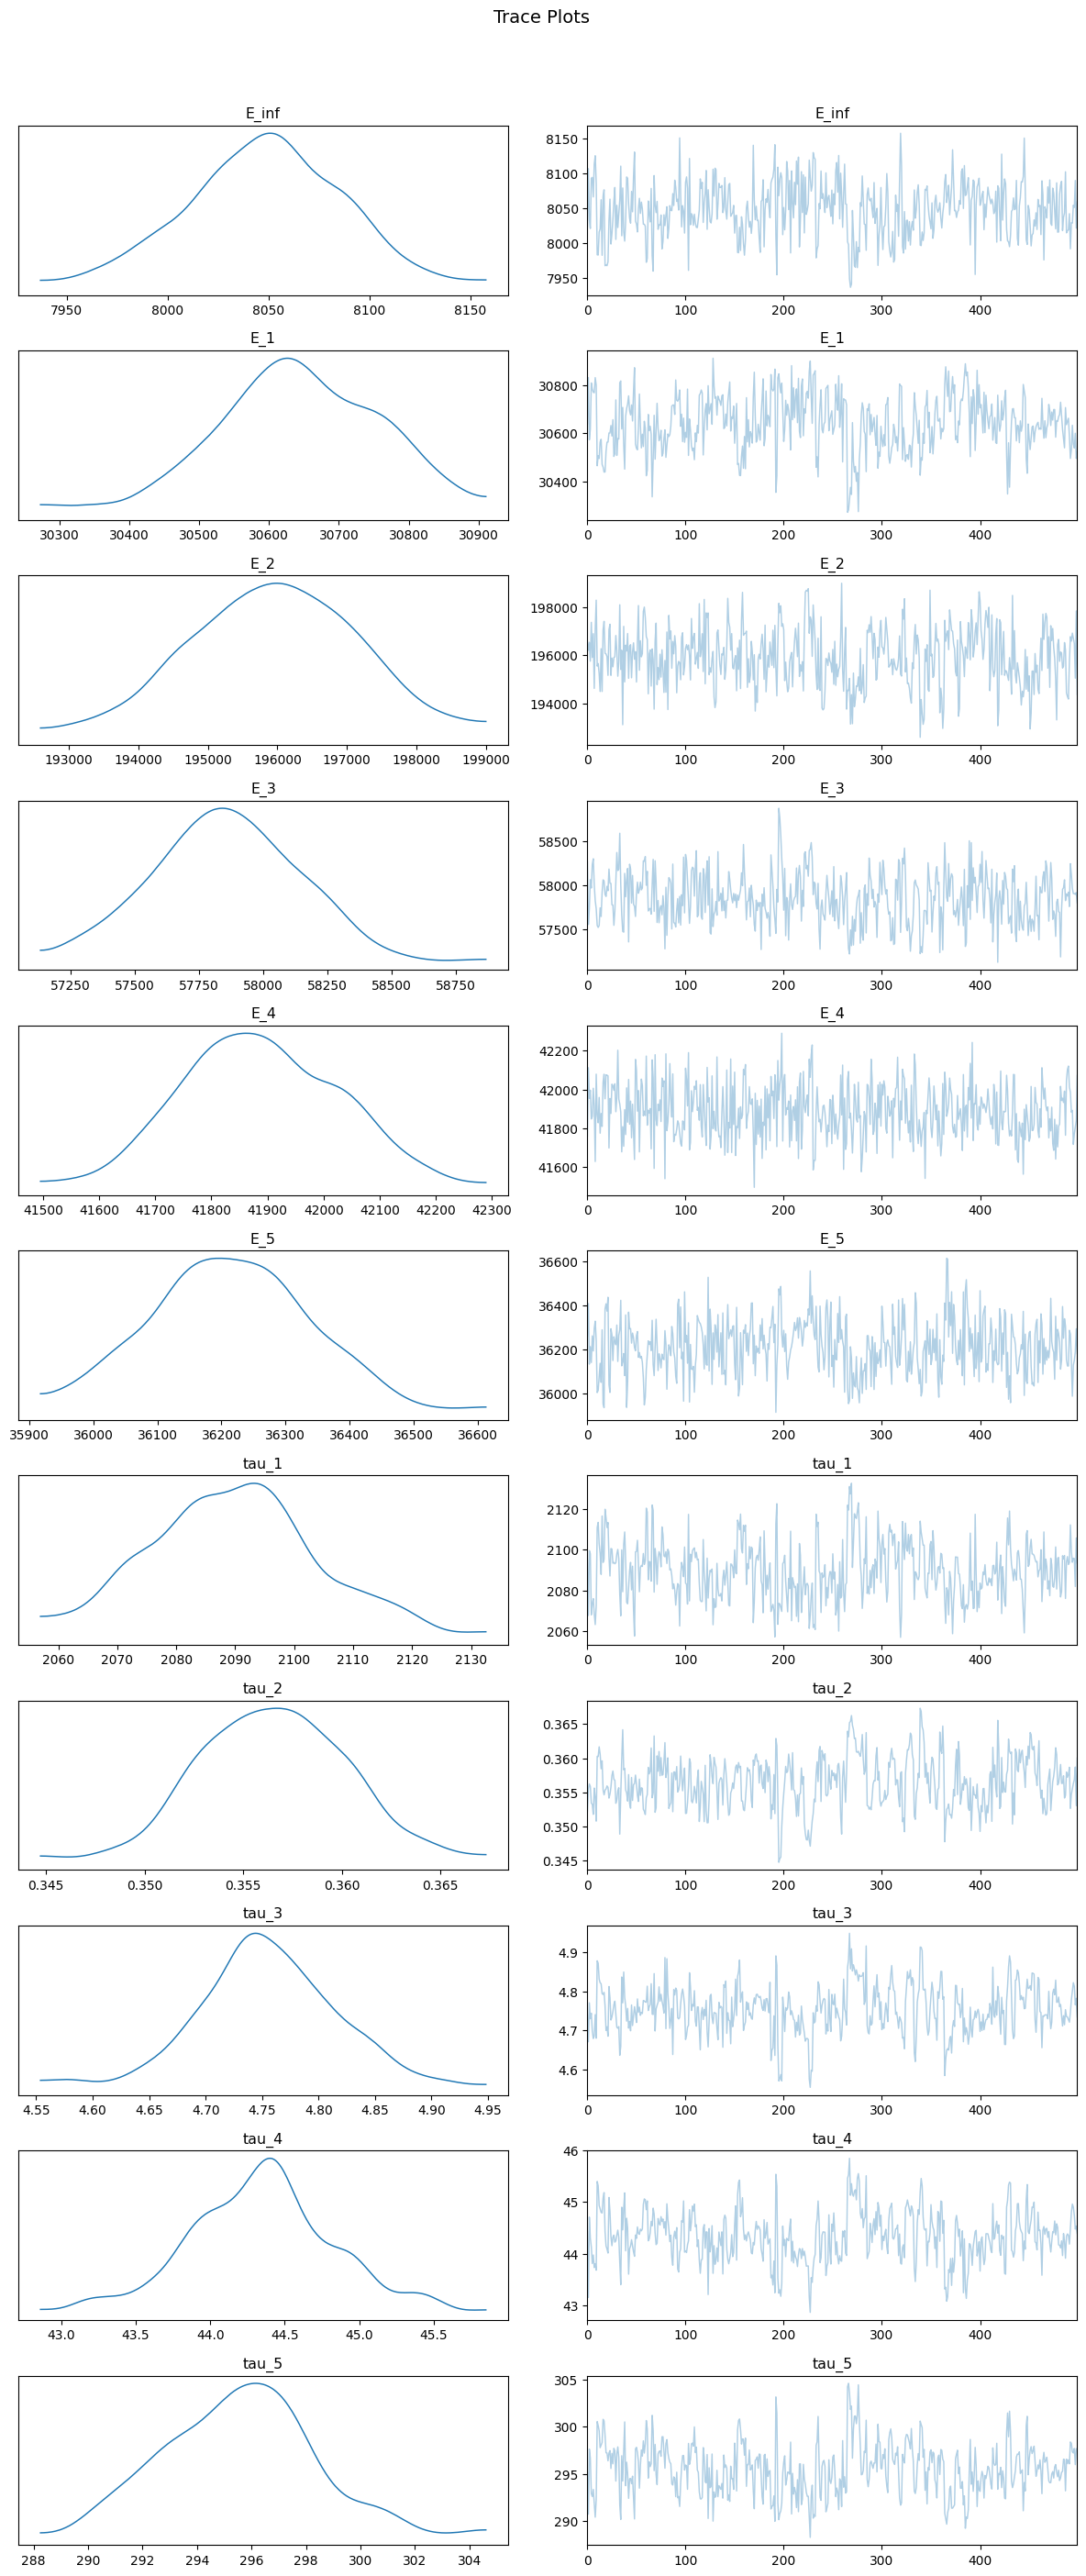

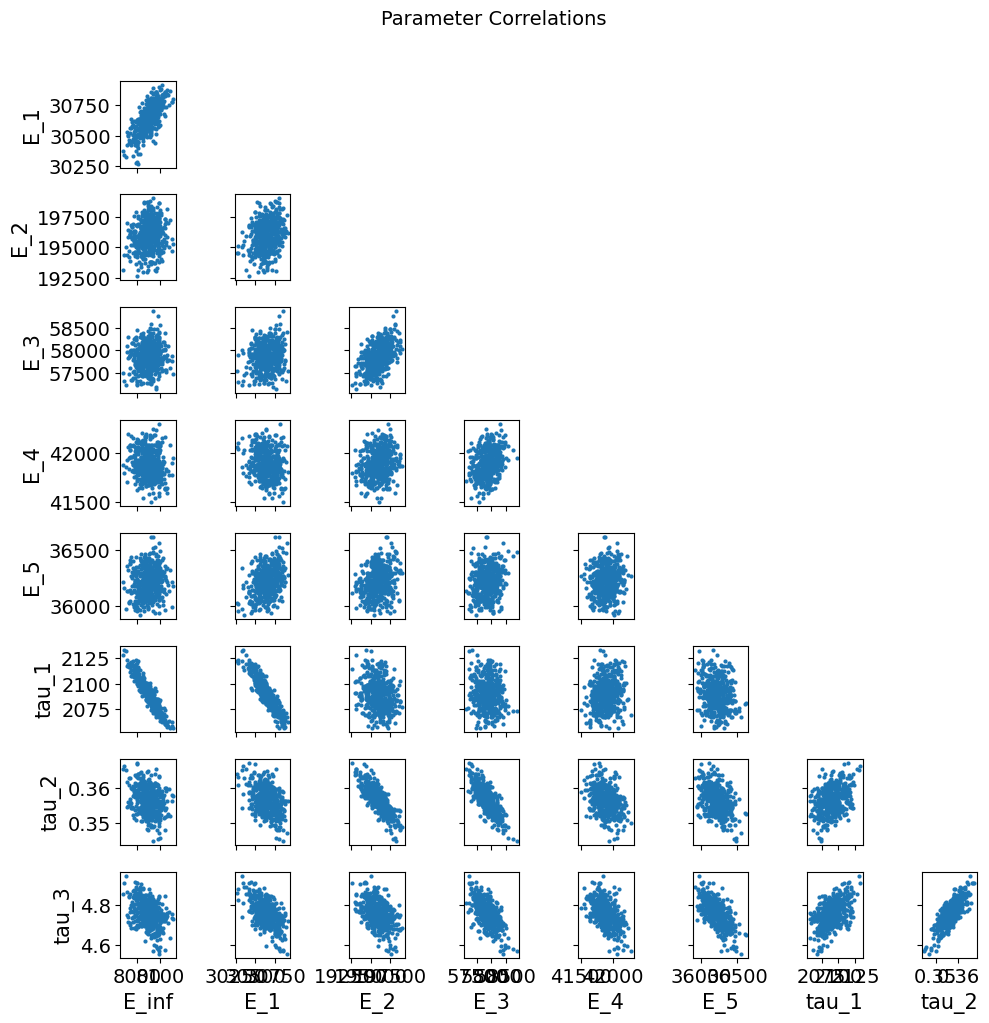

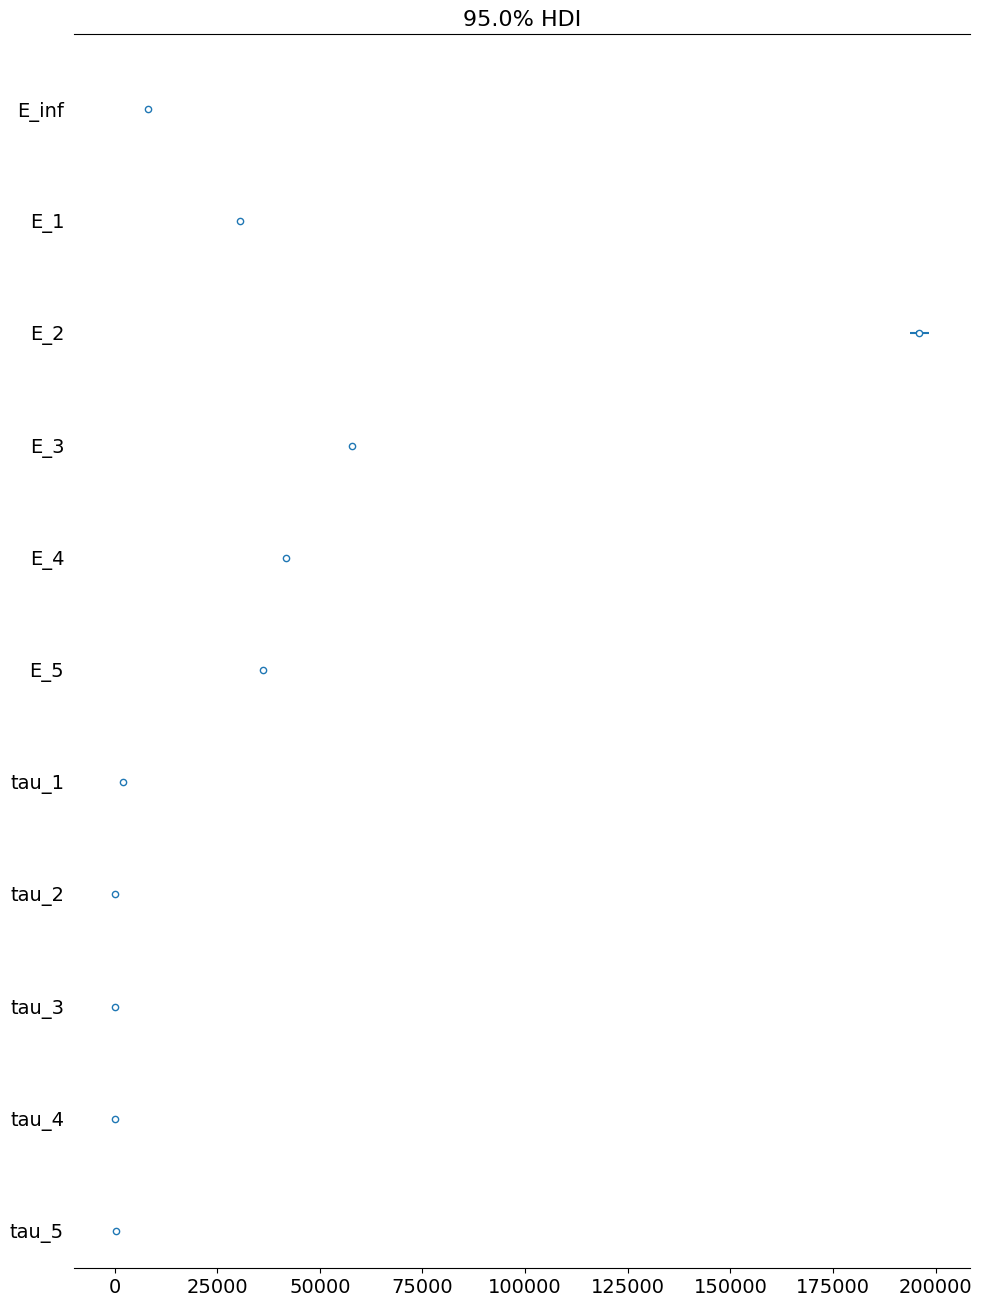

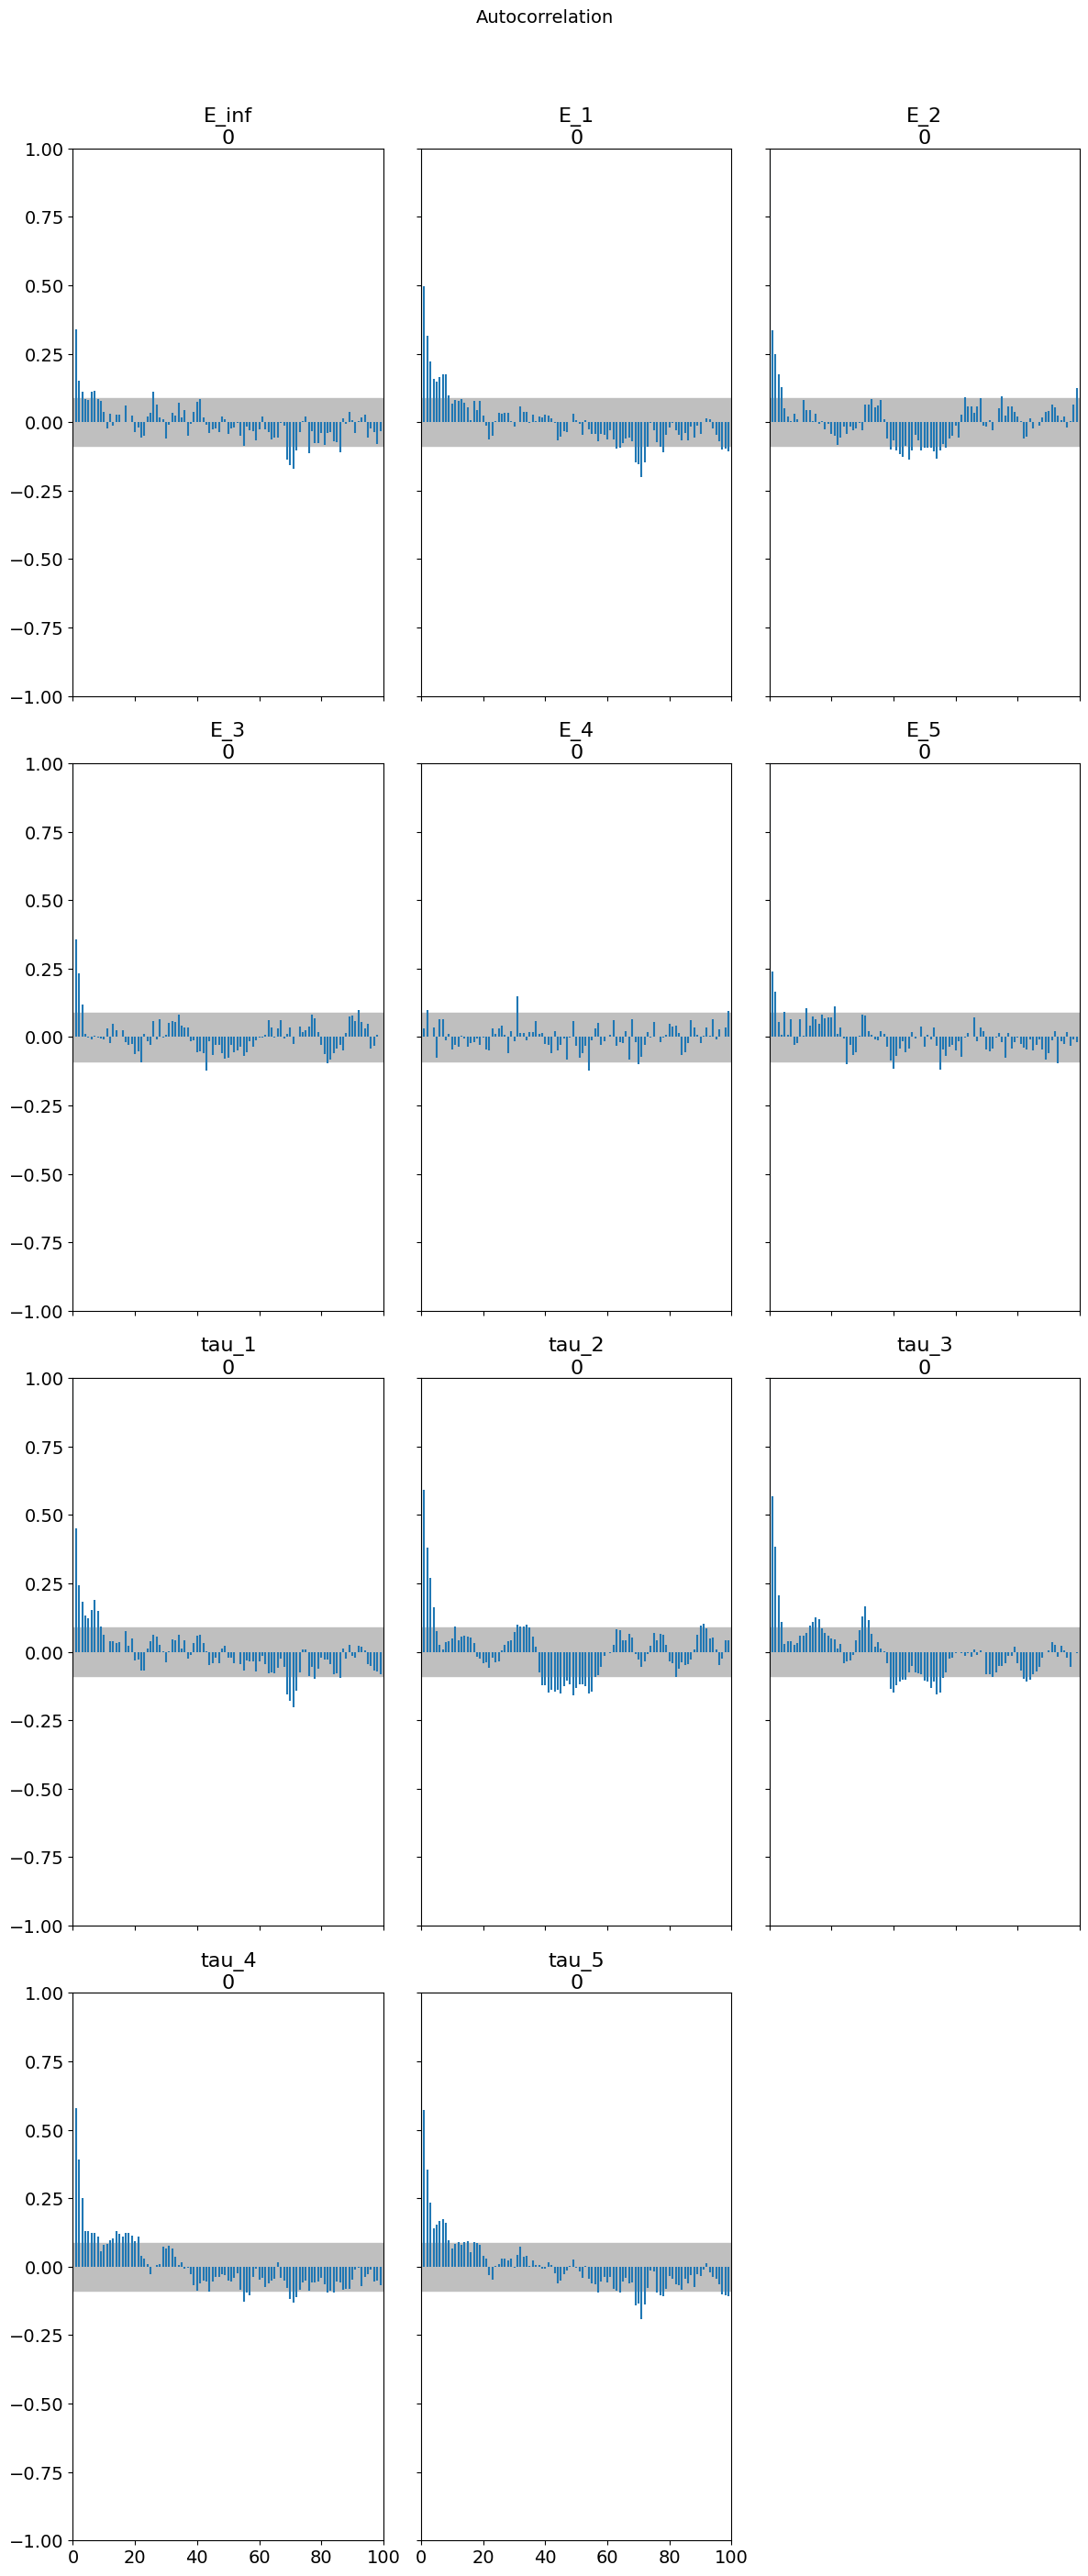

In [10]:
# ArviZ diagnostics for Bayesian results
for ds_idx, (bayes_result, param_names) in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=True)


In [11]:
# Reduce NUTS progress updates: print every 500 samples instead of each iteration
import jax.numpy as jnp
import numpyro.util as numpyro_util
from jax import lax


def progress_bar_factory_every_500(num_samples: int, num_chains: int):
    print_rate = max(1, min(500, num_samples))
    remainder = num_samples % print_rate

    idx_counter = 0
    tqdm_bars = {}
    lock = numpyro_util.Lock()
    for chain in range(num_chains):
        tqdm_bars[chain] = numpyro_util.tqdm_auto(range(num_samples), position=chain)
        tqdm_bars[chain].set_description("Compiling.. ", refresh=True)

    def _update_tqdm(increment, chain):
        increment = int(increment)
        chain = int(chain)
        if chain == -1:
            nonlocal idx_counter
            with lock:
                chain = idx_counter
                idx_counter += 1
        tqdm_bars[chain].set_description(f"Running chain {chain}", refresh=False)
        tqdm_bars[chain].update(increment)
        return chain

    def _close_tqdm(increment, chain):
        increment = int(increment)
        chain = int(chain)
        tqdm_bars[chain].update(increment)
        tqdm_bars[chain].close()

    def _update_progress_bar(iter_num, chain):
        chain = lax.cond(
            iter_num == 1,
            lambda _: numpyro_util.io_callback(_update_tqdm, jnp.array(0), 0, chain),
            lambda _: chain,
            operand=None,
        )
        chain = lax.cond(
            iter_num % print_rate == 0,
            lambda _: numpyro_util.io_callback(_update_tqdm, jnp.array(0), print_rate, chain),
            lambda _: chain,
            operand=None,
        )
        _ = lax.cond(
            iter_num == num_samples,
            lambda _: numpyro_util.io_callback(_close_tqdm, None, remainder, chain),
            lambda _: None,
            operand=None,
        )
        return chain

    def progress_bar_fori_loop(func):
        def wrapper_progress_bar(i, vals):
            subvals, chain = vals
            result = func(i, subvals)
            chain = _update_progress_bar(i + 1, chain)
            return (result, chain)

        return wrapper_progress_bar

    return progress_bar_fori_loop

numpyro_util.progress_bar_factory = progress_bar_factory_every_500
print("Using custom NUTS progress: updates every 500 samples.")


Using custom NUTS progress: updates every 500 samples.
